# Deep Learning: Long Short-Term Memory (LSTM)


## 1. Introduction

Five years of Reliance Industries' historical stock data will be used to predict Adjusted Close prices by building a multi-layer LSTM Recurrent Neural Network model. The ability to store information over a period of time is useful when dealing with time series data. 



## 2. Install/import libraries

In [ ]:
!pip install yfinance 

In [3]:
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import math
import datetime
import keras
import warnings
warnings.filterwarnings('ignore')

from datetime import date, timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

%matplotlib inline

## 3. Import data

Read in RELIANCE INDUSTRIES' stock data for 2016-2021 downloaded from Yahoo! Finance using yfinance API into a pandas DataFrame.

In [4]:
rel_df = yf.download("RELIANCE.NS", start="2016-07-10", end="2021-07-11")
rel_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-07-11,490.847260,492.803711,488.123077,491.590210,479.004242,3815035
2016-07-12,492.952301,497.781525,490.847260,496.989044,484.264832,4507697
2016-07-13,497.880585,503.576599,497.360504,499.638916,486.846863,6883407
2016-07-14,499.316986,502.288818,494.438232,497.731995,484.988770,4964987
2016-07-15,499.762756,505.706421,497.038574,501.347717,488.511902,6457762
...,...,...,...,...,...,...
2021-07-05,2136.449951,2153.550049,2131.500000,2150.199951,2150.199951,5400604
2021-07-06,2144.949951,2148.899902,2120.199951,2124.800049,2124.800049,4647361
2021-07-07,2127.750000,2127.750000,2098.000000,2110.050049,2110.050049,4824931


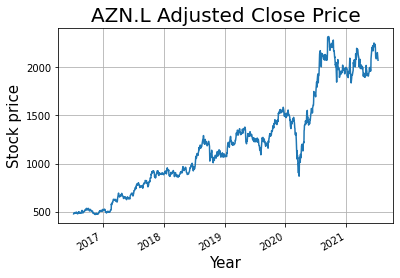

In [5]:
# Plot Adjusted Close price

rel_df['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(16, 8)})
plt.title('AZN.L Adjusted Close Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15);

In [6]:
# Create DataFrame for Adjusted Close price

rel_adj = rel_df[['Adj Close']]

In [9]:
rel_adj.head()

,Adj Close
Date,
2016-07-11,479.004242
2016-07-12,484.264832
2016-07-13,486.846863
2016-07-14,484.988770
2016-07-15,488.511902


## 4. Create training data set

In [11]:
# Convert DataFrame to numpy array
rel_adj_arr = rel_adj.values

# Find number of rows to train model on (80% of data set) 
training_data_len = int(0.8*len(rel_adj))

training_data_len

988

In [12]:
# Create train data set

train = rel_adj_arr[0:training_data_len, :]

### Feature scaling

We will normalise the training data before model fitting by converting the values of numeric columns in the data set to a common scale. Scikit-Learn’s MinMaxScaler() function scales the data to values between 0 and 1 which helps boost performance.

In [ ]:
# Normalise the data
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train)

train_scaled

In [17]:
train_scaled.shape

(988, 1)

## Split training data into X_train, y_train

In [ ]:
# Creating a data structure with 60 time-steps and 1 output

# Split data into X_train and y_train data sets
X_train = []
y_train = []
# Creating a data structure with 60 time-steps and 1 output
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i:i+1, 0])  
    if i <= 61:     # 60 days for first pass, 61 for second
      print(X_train)
      print(y_train)
      print()

In [19]:
# Convert X_train and y_train to numpy arrays for training LSTM model
X_train, y_train = np.array(X_train), np.array(y_train)

In [20]:
# Reshape the data as LSTM expects 3-D data (samples, time steps, features)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(928, 60, 1)

### Create and train model

We will create and train a model with four recurrent layers each with 50 neurons, input shape of data with number of time steps (60) and dimensionality (1), and an output layer with time step of 1, and the tanh activation function. Dropout will be used after each hidden layer as a regularisation technique to prevent overfitting. The model will be compiled using the Mean Squared Error loss function and the adam (Adaptive Moment Estimation) optimizer then fitted on the training set for 200 epochs with a batch size of 64.

In [21]:
# Build model - LSTM with 50 neurons and 4 hidden layers  

model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1), activation='tanh'))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, activation='tanh'))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, activation='tanh'))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, activation='tanh'))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 200, batch_size = 64)

Epoch 1/200
15/15 [==============================] - 21s 187ms/step - loss: 0.0736
Epoch 2/200
15/15 [==============================] - 2s 154ms/step - loss: 0.0152
Epoch 3/200
15/15 [==============================] - 2s 153ms/step - loss: 0.0081
Epoch 4/200
15/15 [==============================] - 2s 153ms/step - loss: 0.0054
Epoch 5/200
15/15 [==============================] - 2s 154ms/step - loss: 0.0053
Epoch 6/200
15/15 [==============================] - 2s 154ms/step - loss: 0.0047
Epoch 7/200
15/15 [==============================] - 2s 155ms/step - loss: 0.0046
Epoch 8/200
15/15 [==============================] - 2s 151ms/step - loss: 0.0055
Epoch 9/200
15/15 [==============================] - 2s 157ms/step - loss: 0.0048
Epoch 10/200
15/15 [==============================] - 2s 151ms/step - loss: 0.0049
Epoch 11/200
15/15 [==============================] - 2s 153ms/step - loss: 0.0044
Epoch 12/200
15/15 [==============================] - 2s 151ms/step - loss: 0.0045
Epoch 13/200

### Create test set

In [22]:
test = rel_adj_arr[training_data_len: , :]

In [23]:
test.shape

(247, 1)

In [24]:
# Predicting 247 values, using past 60 from the train data
inputs = rel_adj_arr[len(rel_adj_arr) - len(test) - 60:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [25]:
# Create data sets X_test and y_test
X_test = []
y_test = rel_adj_arr[training_data_len:, :]
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])

In [26]:
# Convert data to numpy array
X_test = np.array(X_test)

In [27]:
# Reshape data to be 3-D
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [28]:
print(X_test.shape)

(247, 60, 1)


### Make Predictions using the test set

In [29]:
# We want predictions to contain same values as y_test data set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [30]:
predictions.shape

(247, 1)

### Calculate the RMSE using the actual values

RMSE is the standard deviation of the residuals and is a good measure of how accurately the model predicts the reponse. Lower values of RMSE indicate a better fit.

In [31]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)  
rmse

23.299170119559715

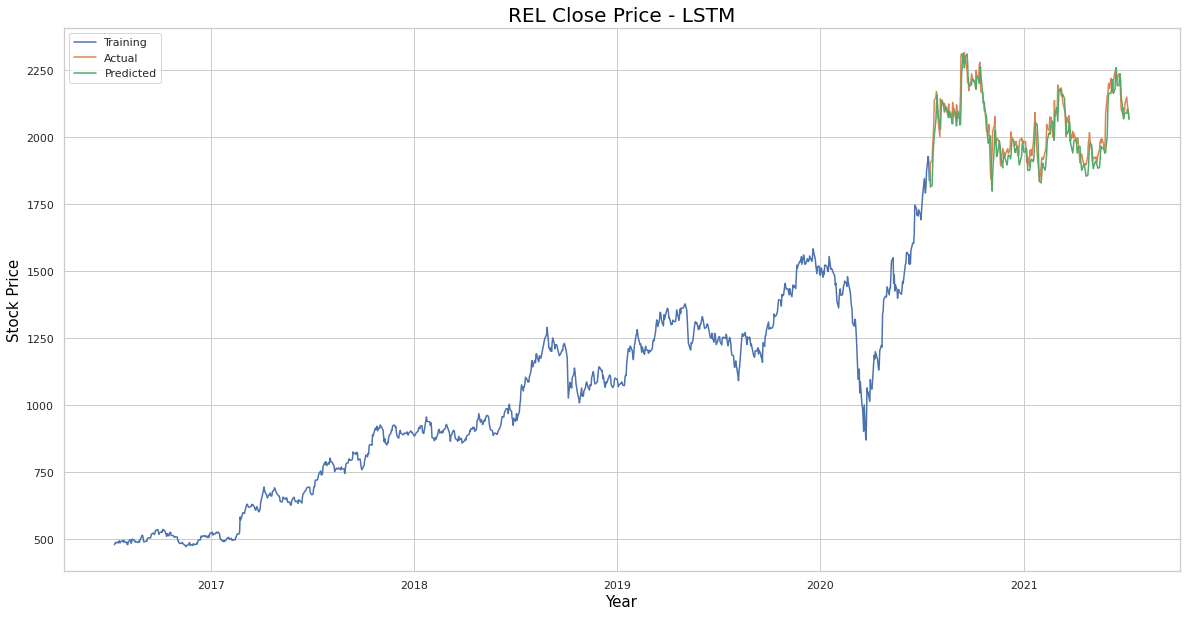

In [32]:
# Plot predicted vs actual values  
train = rel_adj[:training_data_len]
test = rel_adj[training_data_len:]
test['Predictions'] = predictions

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("REL Close Price - LSTM", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();

### DataFrame of actual vs predicted prices plotted above

In [33]:
# Show the actual and predicted prices  

test

,Adj Close,Predictions
Date,,
2020-07-16,1837.489014,1875.964722
2020-07-17,1905.569824,1814.390015
2020-07-20,1913.743652,1820.742432
2020-07-21,1965.228027,1879.309570
2020-07-22,1997.573975,1944.889282
...,...,...
2021-07-05,2150.199951,2090.022217
2021-07-06,2124.800049,2103.784180
2021-07-07,2110.050049,2105.576904


### Predict Adjusted Close price for 12 July 2021

In [41]:
# Predict Adjusted Close price for AZN stock for 11 Jul 2021   
# get the quote
rel_quote = yf.download("RELIANCE.NS", start="2017-07-12", end="2021-07-13")
# Create new df
new_df = rel_quote.filter(['Adj Close'])
# Get last 60 days closing price and convert df to array])
last_60_days = new_df[-60:].values
# Scale data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
# Create empty list
X_test = []
# Append last 60 days 
X_test.append(last_60_days_scaled)
# Convert the X_test data set to numpy array
X_test = np.array(X_test)
# Reshape data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get predicted price
pred_price = model.predict(X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[*********************100%***********************]  1 of 1 completed
[[2048.2712]]


### Actual Adjusted Close price for 12 July 2021

In [40]:
# Actual price
rel_quote2 = yf.download("RELIANCE.NS", start="2021-07-12", end="2021-07-13")
print(rel_quote2['Adj Close'])

[*********************100%***********************]  1 of 1 completed
Date
2021-07-12    2084.100098
Name: Adj Close, dtype: float64


The predicted Adjusted Close price for 12 July 2021 was 2048.3, lower than the actual price of 2084.1. Accuracy could be improved by trying different numbers of layers, epochs and batch sizes. 